In [16]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    f1_score,
    auc,
)


sns.set(style="whitegrid")
sns.set_color_codes("pastel")

In [18]:
full_train = pd.read_csv("datasets/train_clean.csv")

to_drop = [
    "Name",
    "Ticket",
    "Embarked",
    "PassengerId",
    *[c for c in full_train if "cabin" in c.lower()],
]

full_train.drop(columns=to_drop, inplace=True)

target_col = "Survived"

X = full_train.drop(target_col, axis=1)
y = full_train[target_col]

X_train, y_train = X, y

model = KNeighborsClassifier(n_jobs=8)

param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "leaf_size": [10, 20, 30, 40, 50],
    "p": [1, 2],
    "metric": ["minkowski", "euclidean", "manhattan"],
}

# Best Parameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}

param_grid = {
    "n_neighbors": [12, 13, 14],
    "weights": ["uniform"],
    "algorithm": ["auto"],
    "leaf_size": [2, 5, 10, 14],
    "p": [1],
    "metric": ["minkowski"],
}


grid_search = GridSearchCV(
    model, param_grid, n_jobs=1, cv=5, scoring="accuracy", verbose=4
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END algorithm=auto, leaf_size=2, metric=minkowski, n_neighbors=12, p=1, weights=uniform;, score=0.831 total time=   0.1s
[CV 2/5] END algorithm=auto, leaf_size=2, metric=minkowski, n_neighbors=12, p=1, weights=uniform;, score=0.820 total time=   0.0s
[CV 3/5] END algorithm=auto, leaf_size=2, metric=minkowski, n_neighbors=12, p=1, weights=uniform;, score=0.837 total time=   0.0s
[CV 4/5] END algorithm=auto, leaf_size=2, metric=minkowski, n_neighbors=12, p=1, weights=uniform;, score=0.798 total time=   0.0s
[CV 5/5] END algorithm=auto, leaf_size=2, metric=minkowski, n_neighbors=12, p=1, weights=uniform;, score=0.825 total time=   0.0s
[CV 1/5] END algorithm=auto, leaf_size=2, metric=minkowski, n_neighbors=13, p=1, weights=uniform;, score=0.843 total time=   0.0s
[CV 2/5] END algorithm=auto, leaf_size=2, metric=minkowski, n_neighbors=13, p=1, weights=uniform;, score=0.809 total time=   0.0s
[CV 3/5] END algorithm=auto, 

In [19]:
import joblib

joblib.dump(
    grid_search,
    f"../models/{grid_search.best_estimator_.__class__.__name__}_{grid_search.best_score_ * 100:.4f}.joblib",
)

['models/KNeighborsClassifier_82.5652.joblib']

In [20]:
model_name = grid_search.estimator.__class__.__name__

get_best = True  # get the best model or the latest model

# get files in models sorted by last modified
if get_best:
    import os
    import re

    files = os.listdir("../models")
    files = [f for f in files if re.match(f"{model_name}_.*\.joblib", f)]
    files = sorted(
        files, key=lambda x: re.search(r"_(\d+\.\d+)\.joblib", x).group(1), reverse=True
    )
    file_name = files[0]
else:
    import os
    import re

    files = os.listdir("../models")
    files = [f for f in files if re.match(f"{model_name}_.*\.joblib", f)]
    files = sorted(
        files, key=lambda x: os.path.getmtime(os.path.join("models", x)), reverse=True
    )
    file_name = files[0]
loaded_grid_search = joblib.load(f"../models/{file_name}")

In [21]:
for k, v in loaded_grid_search.cv_results_.items():
    print(k, v, sep="\t")

mean_fit_time	[0.00251107 0.00197401 0.00180278 0.00178413 0.00178733 0.00170474
 0.00165148 0.00178313 0.00166368 0.00173283 0.00173841 0.0015491 ]
std_fit_time	[5.37739443e-04 3.40881730e-04 2.20113941e-05 1.09620642e-04
 1.31964078e-04 6.01021792e-05 1.15070835e-04 1.65533249e-04
 4.64560299e-05 2.49729093e-04 2.26298727e-04 6.86277185e-05]
mean_score_time	[0.03286586 0.02023535 0.01315641 0.01296172 0.01192794 0.0117404
 0.0115973  0.01236129 0.01187716 0.01206269 0.01140766 0.01136065]
std_score_time	[0.01807071 0.00914264 0.00089032 0.00125403 0.00032382 0.00062495
 0.00022014 0.00061697 0.0004569  0.00076295 0.00039858 0.00033902]
param_algorithm	['auto' 'auto' 'auto' 'auto' 'auto' 'auto' 'auto' 'auto' 'auto' 'auto'
 'auto' 'auto']
param_leaf_size	[2 2 2 5 5 5 10 10 10 14 14 14]
param_metric	['minkowski' 'minkowski' 'minkowski' 'minkowski' 'minkowski' 'minkowski'
 'minkowski' 'minkowski' 'minkowski' 'minkowski' 'minkowski' 'minkowski']
param_n_neighbors	[12 13 14 12 13 14 12 13 

In [22]:
real_test = pd.read_csv("datasets/test_clean.csv")

In [23]:
real_test.drop(columns=list(set(to_drop) - {"PassengerId"}), inplace=True)

In [24]:
pred = pd.DataFrame(best_model.predict(real_test.drop(columns=["PassengerId"]))).rename(
    columns={0: "Survived"}
)

In [25]:
# get probabilities
probs = best_model.predict_proba(X_train)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# predict class values
yhat = best_model.predict(X_train)

# calculate roc-auc score
lr_auc = roc_auc_score(y_train, probs)

# calculate roc curve
ns_fpr, ns_tpr, _ = roc_curve(y_train, probs)

# get f1 score
lr_f1 = f1_score(y_train, best_model.predict(X_train))

# get auc score
lr_auc = auc(ns_fpr, ns_tpr)

# get precision & recall
lr_precision, lr_recall, _ = precision_recall_curve(y_train, probs)

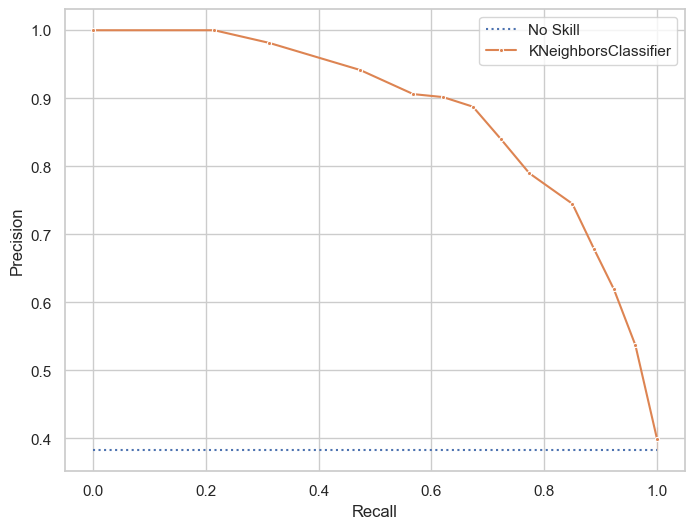

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get no-skill line
no_skill = len(y_train[y_train == 1]) / len(y_train)

# Set the style
sns.set(style="whitegrid")

# Plot the precision-recall curves
plt.figure(figsize=(8, 6))
sns.lineplot(x=[0, 1], y=[no_skill, no_skill], linestyle="dotted", label="No Skill")
sns.lineplot(x=lr_recall, y=lr_precision, marker=".", label=model_name)

# Set axis labels
plt.xlabel("Recall")
plt.ylabel("Precision")

# Show the legend
plt.legend()

# Show the plot
plt.show()

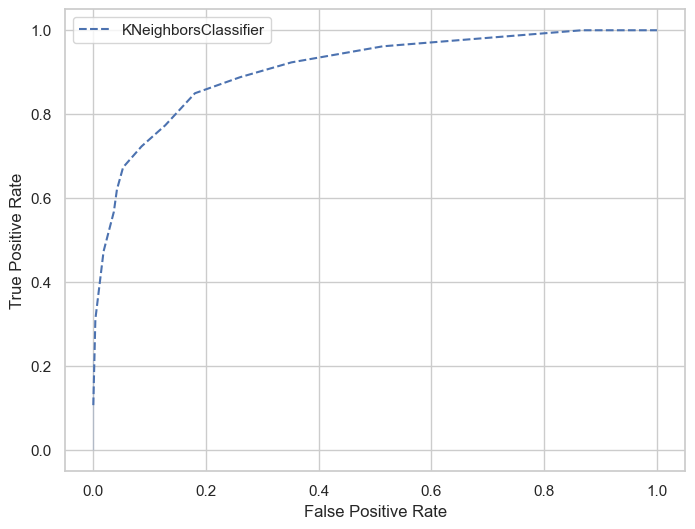

In [27]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=ns_fpr, y=ns_tpr, linestyle="--", label=model_name)

# Set axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Show the legend
plt.legend()

# Show the plot
plt.show()

In [28]:
pd.concat([real_test[["PassengerId"]], pred], axis=1).to_csv(
    f"../outs/{best_model.__class__.__name__}_{grid_search.best_score_ * 100:.4f}.csv",
    index=False,
)